In [1]:
import os
import torch
import numpy as np
import pandas as pd

os.chdir("..")

from matplotlib import pyplot as plt
from lib import *
from pathlib import Path
from semseg_model import *
from glob import glob

images_dir = Path('/mnt/z/data_science/dataset')
checkpoint_dir = Path('/mnt/z/data_science/checkpoints')

%matplotlib inline

### Задача

### Модель


В качестве бейзлайна взял Unet и не прогадал, оказалось, что лучше всего работает как раз он. В качестве энкодера лучше всех подошел маленький efficient net b0. Возможно, имеет смысл сделать модель еще меньше. Просто не успеваю найти что-то совсем маленькое.

Оптимайзер - Адам, с ним в принципе нормально учится. 

Лоссы - экспериментировал с лоссами из статьи (A survey of loss functions for semantic segmentation, Jadon). DICE loss лучше всего работает.

Аугментаций взял много. 

In [2]:
baseline_model =  torch.load(checkpoint_dir / 'unet_effnetb0_20epochs.pth')

In [3]:
model_2 =  torch.load(checkpoint_dir / 'unet_resnet18_20epochs.pth')

In [4]:
model_3 =  torch.load(checkpoint_dir / 'unet_eff0_aug_tuned_20epochs.pth')

In [13]:
model_4 = torch.load(checkpoint_dir / 'unet_eff0_aug_tuned_tversky8-2_20epochs.pth')

### Основные метрики

Смотрим на DICE и IoU. Так как основная проблема - переобучение, я переключился с метрик на соотношение лосса на трейне и тесте, чтобы его контроллировать. 
Аугментации брал из тех, что я знаю, ну в статьях пишут, что для этой задачи они примерно такие же, как и в остальном CV. 
В основном тюнил интенсивность аугментаций и смотрел на инференс на тесте. 

## baseline

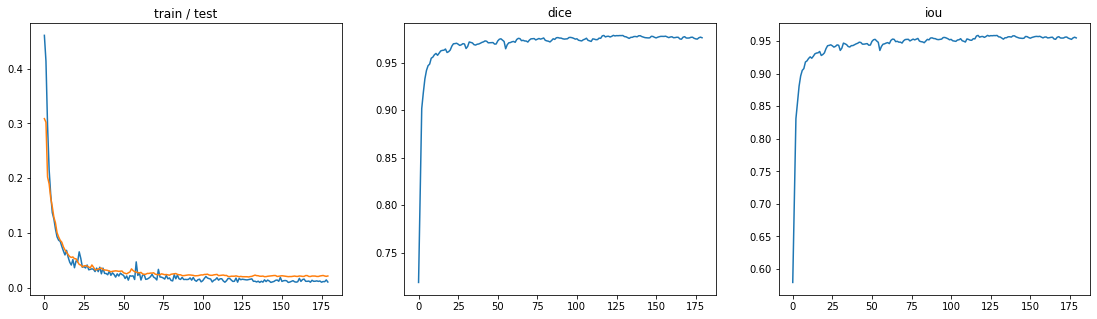

dice 0.975967288017273
iou 0.9550186395645142
0.021337133 0.012440667


In [10]:
plt.figure(figsize=(19, 5))
plt.subplot(1, 3, 1)
plt.title('train / test')
plt.plot(baseline_model.log['train'])
plt.plot(baseline_model.log['test'])
plt.subplot(1, 3, 2)
plt.title('dice')
plt.plot(baseline_model.log['dice'])
plt.subplot(1, 3, 3)
plt.title('iou')
plt.plot(baseline_model.log['iou'])
plt.show()
mean_dice = np.mean(baseline_model.log['dice'][-10:])
mean_iou = np.mean(baseline_model.log['iou'][-10:])
print(f'dice {mean_dice}')
print(f'iou {mean_iou}')
print(np.mean(baseline_model.log['test'][-20:]), np.mean(baseline_model.log['train'][-20:]))

## baseline but with resnet_18 as encoder

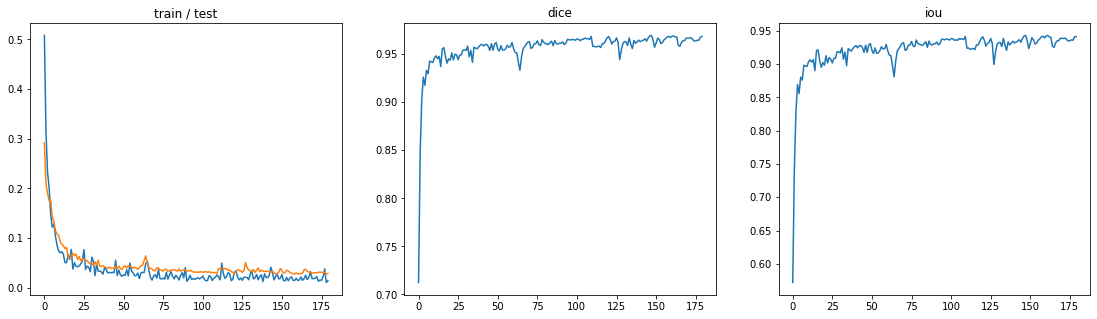

dice 0.9659295082092285
iou 0.9376166462898254
0.031035516 0.019720962


In [11]:
plt.figure(figsize=(19, 5))
plt.subplot(1, 3, 1)
plt.title('train / test')
plt.plot(model_2.log['train'])
plt.plot(model_2.log['test'])
plt.subplot(1, 3, 2)
plt.title('dice')
plt.plot(model_2.log['dice'])
plt.subplot(1, 3, 3)
plt.title('iou')
plt.plot(model_2.log['iou'])
plt.show()
mean_dice = np.mean(model_2.log['dice'][-10:])
mean_iou = np.mean(model_2.log['iou'][-10:])
print(f'dice {mean_dice}')
print(f'iou {mean_iou}')
print(np.mean(model_2.log['test'][-20:]), np.mean(model_2.log['train'][-20:]))

## baseline + augs (тест лосс как на трейне, сходимость лучше, но f1 не улучшился. Визуально инференс теста лучше выглядит)

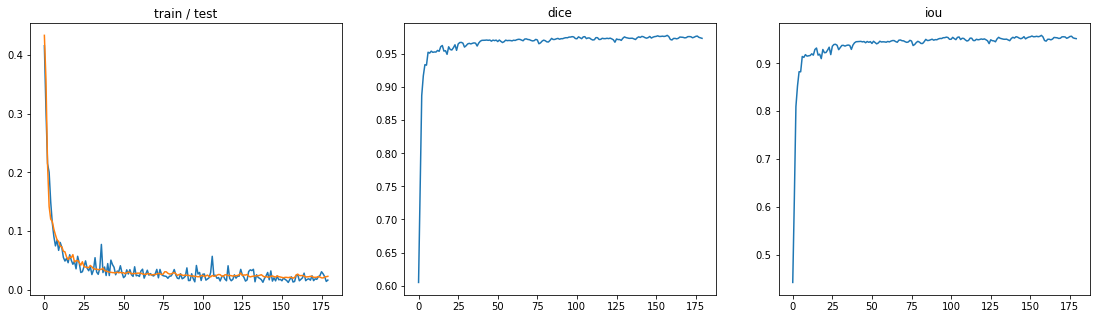

dice 0.9756866693496704
iou 0.9540039300918579
0.022882346 0.020809257


In [12]:
plt.figure(figsize=(19, 5))
plt.subplot(1, 3, 1)
plt.title('train / test')
plt.plot(model_3.log['train'])
plt.plot(model_3.log['test'])
plt.subplot(1, 3, 2)
plt.title('dice')
plt.plot(model_3.log['dice'])
plt.subplot(1, 3, 3)
plt.title('iou')
plt.plot(model_3.log['iou'])
plt.show()
mean_dice = np.mean(model_3.log['dice'][-10:])
mean_iou = np.mean(model_3.log['iou'][-10:])
print(f'dice {mean_dice}')
print(f'iou {mean_iou}')
print(np.mean(model_3.log['test'][-20:]), np.mean(model_3.log['train'][-20:]))

## baseline + augs + Tversky loss (alpha = 0.8, beta - 0.2)

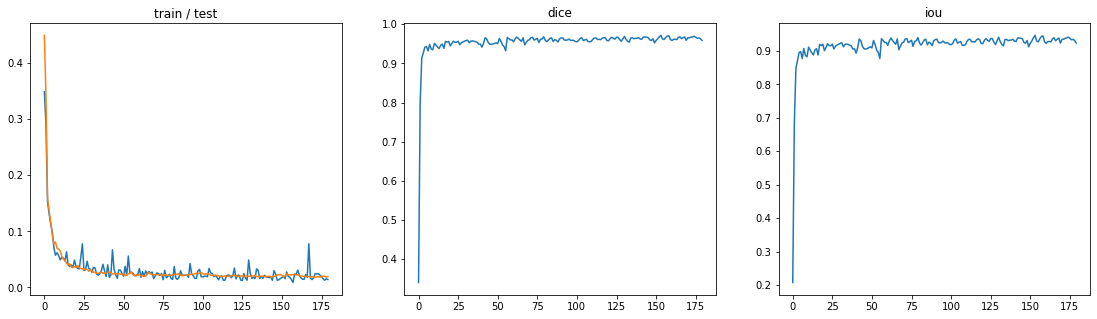

dice 0.9652683138847351
iou 0.9346778988838196
0.01951982 0.021916116


In [14]:
plt.figure(figsize=(19, 5))
plt.subplot(1, 3, 1)
plt.title('train / test')
plt.plot(model_4.log['train'])
plt.plot(model_4.log['test'])
plt.subplot(1, 3, 2)
plt.title('dice')
plt.plot(model_4.log['dice'])
plt.subplot(1, 3, 3)
plt.title('iou')
plt.plot(model_4.log['iou'])
plt.show()
mean_dice = np.mean(model_4.log['dice'][-10:])
mean_iou = np.mean(model_4.log['iou'][-10:])
print(f'dice {mean_dice}')
print(f'iou {mean_iou}')
print(np.mean(model_4.log['test'][-20:]), np.mean(model_4.log['train'][-20:]))

Выбрал модель номер три, но меня лично качество не устраивает. 

Какие есть идеи, которые не успел попробовать?

Надо взять несколько фонов и повставлять в них маски, чтобы масштаб человека на изображении был меньше. 
Надо написать кастомную голову из нескольких слоев, встроить в нее батчнорм и дропаут и попробовать учить дольше с зафриженой основной моделью.
Можно подергать фурье фичи из проблемных изображений и попробовать делать аугментацию высокочастотных фичей.

Эксперименты с разным способом инференса я делал, но возможно есть какой-то набор test-time augmentations, который даст прирост. Видел такие статьи. 

NB
Выучиваются слишком резкие вероятности, распределение сдвинуто к 0 и 1. Поэтому адекватный постпроцессинг сходу не накинуть. Надо думать. 


In [8]:
ds_infer =  MapDataset(images_dir, (224, 224), 'valid', with_masks=False)
dl_infer =  torch.utils.data.DataLoader(ds_infer, batch_size=4, shuffle=False)

In [19]:
paths_to_imgs = sorted(glob("/mnt/z/data_science/dataset/test/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("/mnt/z/data_science/dataset/test_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

In [20]:
pred = pd.read_csv("data/pred_valid_template.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'data/pred_valid_template.csv'